**Assignment 1 Task 4: Logistic Regression versus Bayes Classifier**  
**Student ID = 31237223**  
**Name = Yee Darren Jer Shien**

**Question 7: Load Breast Cancer Database**

In [1]:
from sklearn.datasets import load_breast_cancer
import numpy as np

cancer = load_breast_cancer()
cancer.data.shape, cancer.target.shape, cancer.feature_names

((569, 30),
 (569,),
 array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension',
        'radius error', 'texture error', 'perimeter error', 'area error',
        'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error',
        'fractal dimension error', 'worst radius', 'worst texture',
        'worst perimeter', 'worst area', 'worst smoothness',
        'worst compactness', 'worst concavity', 'worst concave points',
        'worst symmetry', 'worst fractal dimension'], dtype='<U23'))

**Question 7: Train Test Split**

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
x_train_cancer, x_test_cancer, y_train_cancer, y_test_cancer = train_test_split(cancer.data, cancer.target, train_size=0.8, random_state=1)

**Question 7: Bayes Classifier Imported from Activity 3.3**

In [4]:
from scipy.stats import multivariate_normal

class BayesianClassifier:

    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov=shared_cov
        self.cond_ind=cond_ind

    def fit(self, x, y):
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_ , self.p_ = x.shape
        self.k_ = len(self.classes_)
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))
        
        self.class_priors_ = class_counts/len(y)
        for c in range(self.k_):
            c_rows = y==c
            self.cond_means_[c, :] = x[c_rows].mean(axis=0)
            if self.cond_ind:
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            # find p(x | c_k)
            # singular covariance matrices could happen (e.g., through inaccurate estimation)
            cond_probs[:, c] = multivariate_normal.pdf(x, 
                                                       self.cond_means_[c],
                                                       self.cond_covs_[c],
                                                       allow_singular=True)
        # find marginal probabilities p(x) by summing all the conditionals weighted by the priors
        marginal_probs = cond_probs.dot(self.class_priors_)

        # find probability vector (p(c1 | x), ..., p(ck | x)) via p(ci | x)=p(x | ci) / p(x)
        # however, p(x) might have been rounded to 0
        # thus, compute via case distinction
        probs = np.divide((cond_probs*self.class_priors_).T,
                          marginal_probs,
                          where=marginal_probs>0, out=np.zeros(shape=(self.k_, m))).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1]/probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c]=np.log(probs[:, c]/(1-probs[:, c]))
            return res
        
    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state)

**Question 7: Import Logistic Regression**

In [5]:
from sklearn.linear_model import LogisticRegression

**Question 7: Evaluate Performance**

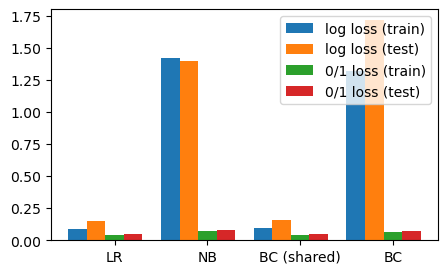

In [6]:
from sklearn.metrics import zero_one_loss, log_loss
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore', message='The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.')

def plot_model_performances(models, model_names, x_train, y_train, x_test, y_test):
    train_01_losses = []
    train_log_losses = []
    test_01_losses = []
    test_log_losses = []
    
    for i, model in enumerate(models):
        train_01_losses.append(zero_one_loss(y_train, model.predict(x_train)))
        train_log_losses.append(log_loss(y_train, model.predict_proba(x_train)))
        test_01_losses.append(zero_one_loss(y_test, model.predict(x_test)))
        test_log_losses.append(log_loss(y_test, model.predict_proba(x_test)))

    xx = np.arange(len(models))
    bar_width = 1/(len(models)+1)
    group_width = len(models)*bar_width
    plt.bar(xx-group_width/2, train_log_losses, width=bar_width, label='log loss (train)')
    plt.bar(xx-group_width/2 + bar_width, test_log_losses, width=bar_width, label='log loss (test)')
    plt.bar(xx-group_width/2 + 2*bar_width, train_01_losses, width=bar_width, label='0/1 loss (train)')
    plt.bar(xx-group_width/2 +3*bar_width, test_01_losses, width=bar_width, label='0/1 loss (test)')
    plt.xticks(xx, model_names)

logistic = LogisticRegression(random_state=1,max_iter = 10000).fit(x_train_cancer,y_train_cancer)
nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train_cancer, y_train_cancer)
bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train_cancer, y_train_cancer)
bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train_cancer, y_train_cancer)

models = [logistic, nb, bc_shared, bc]
model_names = ['LR', 'NB', 'BC (shared)', 'BC']

plt.subplots(1, 1, figsize=(5, 3))
plot_model_performances(models, model_names, x_train_cancer, y_train_cancer, x_test_cancer, y_test_cancer)
plt.legend()
plt.show()


**Question 7.2 Evaluate performance based on different N**

In [7]:
def generate_model_performance ():
    model_names = ['LR', 'NB', 'BC (shared)', 'BC']
    N_list = list(range(5, 501, 5))
    model_rest_log = []
    model_rest_nb = []
    model_rest_bc_shared= []
    model_rest_bc = []

    for N in N_list:
        train_01_losses = [[] for _ in range (len(model_names))]
        train_log_losses = [[] for _ in range (len(model_names))]
        test_01_losses = [[] for _ in range (len(model_names))]
        test_log_losses = [[] for _ in range (len(model_names))]
        for it in range (10):
            x_train_cancer, x_test_cancer, y_train_cancer, y_test_cancer = train_test_split(cancer.data, cancer.target, train_size = N,random_state = it)
            while (len(np.unique(y_train_cancer)) == 1):
                    x_train_cancer, x_test_cancer, y_train_cancer, y_test_cancer = train_test_split(cancer.data, cancer.target, train_size = 5)
            logistic = LogisticRegression(random_state=1,max_iter = 5000).fit(x_train_cancer,y_train_cancer)
            nb = BayesianClassifier(shared_cov=False, cond_ind=True).fit(x_train_cancer, y_train_cancer)
            bc_shared = BayesianClassifier(shared_cov=True, cond_ind=False).fit(x_train_cancer, y_train_cancer)
            bc = BayesianClassifier(shared_cov=False, cond_ind=False).fit(x_train_cancer, y_train_cancer)
            models = [logistic, nb, bc_shared, bc]
            for i, model in enumerate(models):
                train_01_losses[i].append(zero_one_loss(y_train_cancer, model.predict(x_train_cancer)))
                train_log_losses[i].append(log_loss(y_train_cancer, model.predict_proba(x_train_cancer)))
                test_01_losses[i].append(zero_one_loss(y_test_cancer, model.predict(x_test_cancer)))
                test_log_losses[i].append(log_loss(y_test_cancer, model.predict_proba(x_test_cancer)))
        train_01_losses_agg = [np.mean(sublist) for sublist in train_01_losses]
        train_log_losses_agg = [np.mean(sublist) for sublist in train_log_losses]
        test_01_losses_agg = [np.mean(sublist) for sublist in test_01_losses]
        test_log_losses_agg = [np.mean(sublist) for sublist in test_log_losses]
        model_rest_log.append([train_01_losses_agg[0],train_log_losses_agg[0],test_01_losses_agg[0],test_log_losses_agg[0]])
        model_rest_nb.append([train_01_losses_agg[1],train_log_losses_agg[1],test_01_losses_agg[1],test_log_losses_agg[1]])
        model_rest_bc_shared.append([train_01_losses_agg[2],train_log_losses_agg[2],test_01_losses_agg[2],test_log_losses_agg[2]])
        model_rest_bc.append([train_01_losses_agg[3],train_log_losses_agg[3],test_01_losses_agg[3],test_log_losses_agg[3]])
    return model_rest_log,model_rest_nb,model_rest_bc_shared,model_rest_bc

**Question 7.2 Method to plot performance for data evauluation method above**

In [8]:
def plot_model_performances_N(model_rest_log,model_rest_nb,model_rest_bc_shared,model_rest_bc, type):
    n_list = [f'{n}' for n in range(5, 501, 5)]
    model_rest_log = np.array(model_rest_log)
    model_rest_nb = np.array(model_rest_nb)
    model_rest_bc_shared = np.array(model_rest_bc_shared)
    model_rest_bc = np.array(model_rest_bc)

    train_01_losses_log = model_rest_log[:, 0]
    train_log_losses_log = model_rest_log[:, 1]
    test_01_losses_log = model_rest_log[:, 2]
    test_log_losses_log = model_rest_log[:, 3]
    train_01_losses_nb = model_rest_nb[:, 0]
    train_log_losses_nb = model_rest_nb[:, 1]
    test_01_losses_nb = model_rest_nb[:, 2]
    test_log_losses_nb = model_rest_nb[:, 3]
    train_01_losses_bc_shared = model_rest_bc_shared[:, 0]
    train_log_losses_bc_shared = model_rest_bc_shared[:, 1]
    test_01_losses_bc_shared = model_rest_bc_shared[:, 2]
    test_log_losses_bc_shared = model_rest_bc_shared[:, 3]
    train_01_losses_bc = model_rest_bc[:, 0]
    train_log_losses_bc = model_rest_bc[:, 1]
    test_01_losses_bc = model_rest_bc[:, 2]
    test_log_losses_bc = model_rest_bc[:, 3]
    
    xx = np.arange(len(n_list))
    bar_width = 0.2
    plt.figure(figsize=(12, 8))
    if type == 1:
        plt.title('Train 01 Losses for Each N')
        plt.plot(xx - 2, train_01_losses_log, label='0/1 loss (train) Logistic Regression', color='b', marker='o')
        plt.plot(xx - 2, train_01_losses_nb, label='0/1 loss (train) Naive Bayes', color='g', marker='o')
        plt.plot(xx - 2, train_01_losses_bc_shared, label='0/1 loss (train) Bayes Shared Covariance', color='r', marker='o')
        plt.plot(xx - 2, train_01_losses_bc, label='0/1 loss (train) Bayes No Shared Covariance', color='y', marker='o')

    elif type == 2:
        plt.title('Log Train Losses for Each N')
        plt.plot(xx - 2, train_log_losses_log, label='log loss (train) Logistic Regression', color='b', marker='o')
        plt.plot(xx - 2, train_log_losses_nb, label='log loss (train) Naive Bayes', color='g', marker='o')
        plt.plot(xx - 2, train_log_losses_bc_shared, label='log loss (train) Bayes Shared Covariance', color='r', marker='o')
        plt.plot(xx - 2, train_log_losses_bc, label='log loss (train) Bayes No Shared Covariance', color='y', marker='o')    
    
    elif type == 3:
        plt.title('Test 01 Losses for Each N')
        plt.plot(xx - 2, test_01_losses_log, label='0/1 loss (test) Logistic Regression', color='b', marker='o')
        plt.plot(xx - 2, test_01_losses_nb, label='0/1 loss (test) Naive Bayes', color='g', marker='o')
        plt.plot(xx - 2, test_01_losses_bc_shared, label='0/1 loss (test) Bayes Shared Covariance', color='r', marker='o')
        plt.plot(xx - 2, test_01_losses_bc, label='0/1 loss (test) Bayes No Shared Covariance', color='y', marker='o')
    else:
        plt.title('Log Test Losses for Each N')
        plt.plot(xx - 2, test_log_losses_log, label='log loss (test) Logistic Regression', color='b', marker='o')
        plt.plot(xx - 2, test_log_losses_nb, label='log loss (test) Naive Bayes', color='g', marker='o')
        plt.plot(xx - 2, test_log_losses_bc_shared, label='log loss (test) Bayes Shared Covariance', color='r', marker='o')
        plt.plot(xx - 2, test_log_losses_bc, label='log loss (test) Bayes No Shared Covariance', color='y', marker='o')
        
    plt.xticks(xx, n_list, fontsize=8,rotation=90)
    plt.xlabel('N')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

**Question 7.2 Generate Model Performance Data**

In [9]:
model_rest_log,model_rest_nb,model_rest_bc_shared,model_rest_bc = generate_model_performance()

**Question 7.3 Plot Model Performance for the four losses for Logistic Regression**

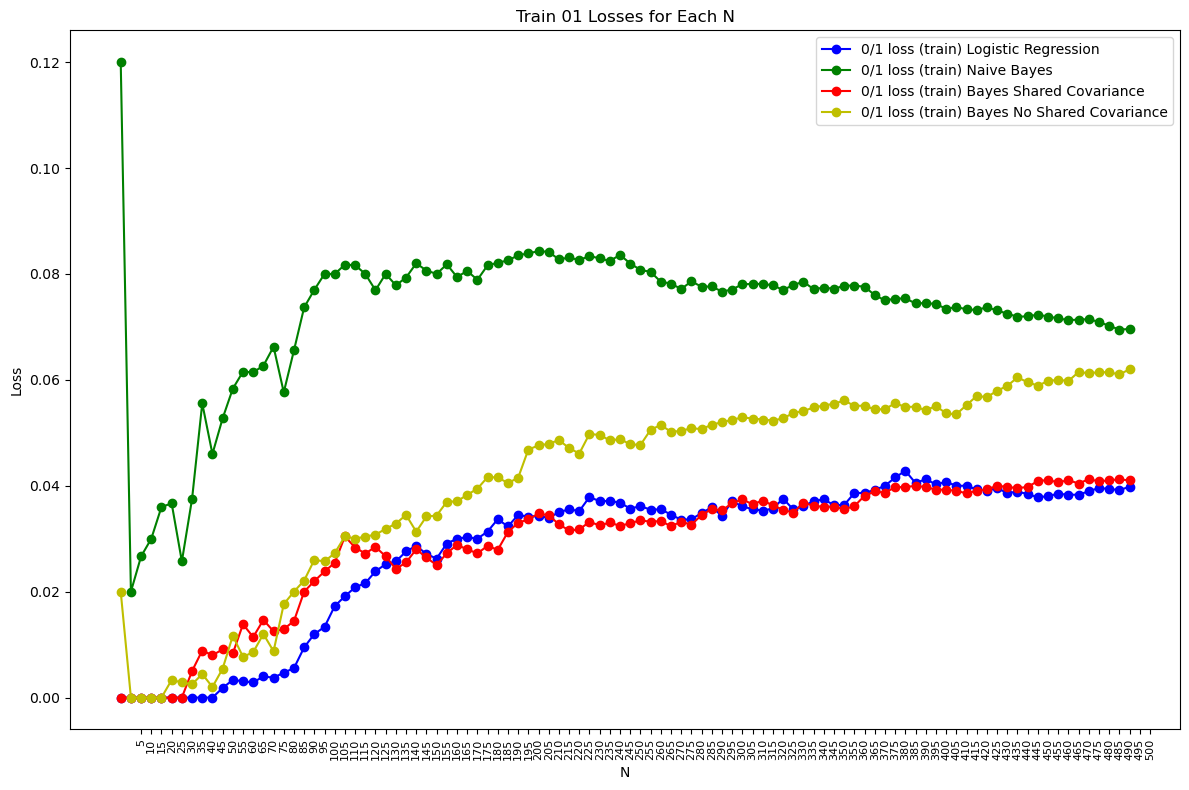

In [10]:
plot_model_performances_N (model_rest_log,model_rest_nb,model_rest_bc_shared,model_rest_bc,1)

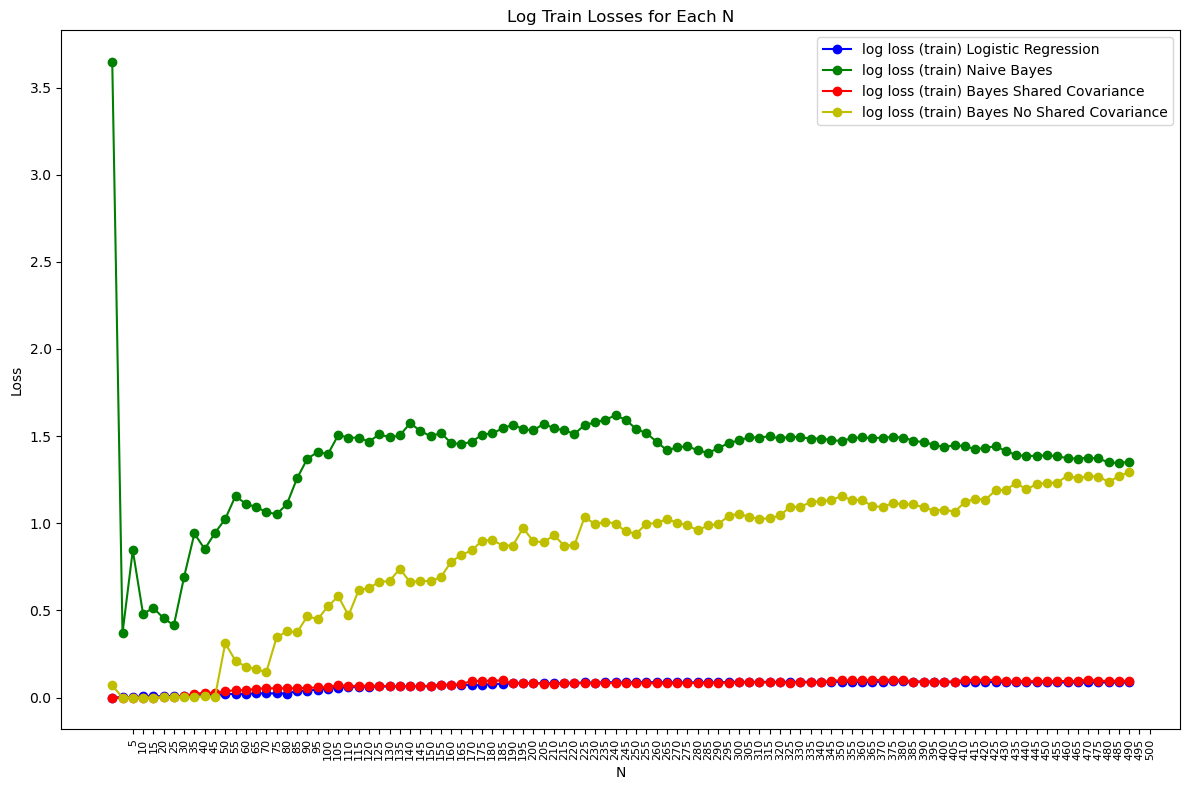

In [11]:
plot_model_performances_N (model_rest_log,model_rest_nb,model_rest_bc_shared,model_rest_bc,2)

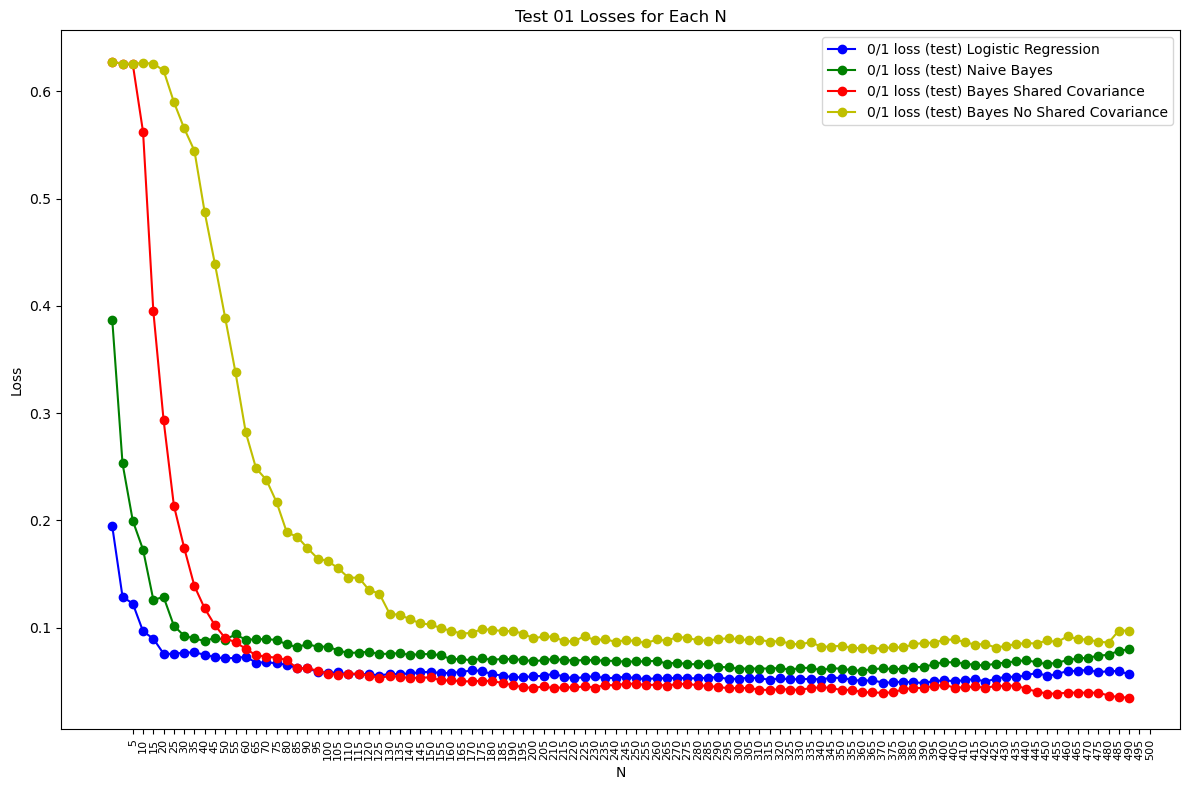

In [12]:
plot_model_performances_N (model_rest_log,model_rest_nb,model_rest_bc_shared,model_rest_bc,3)

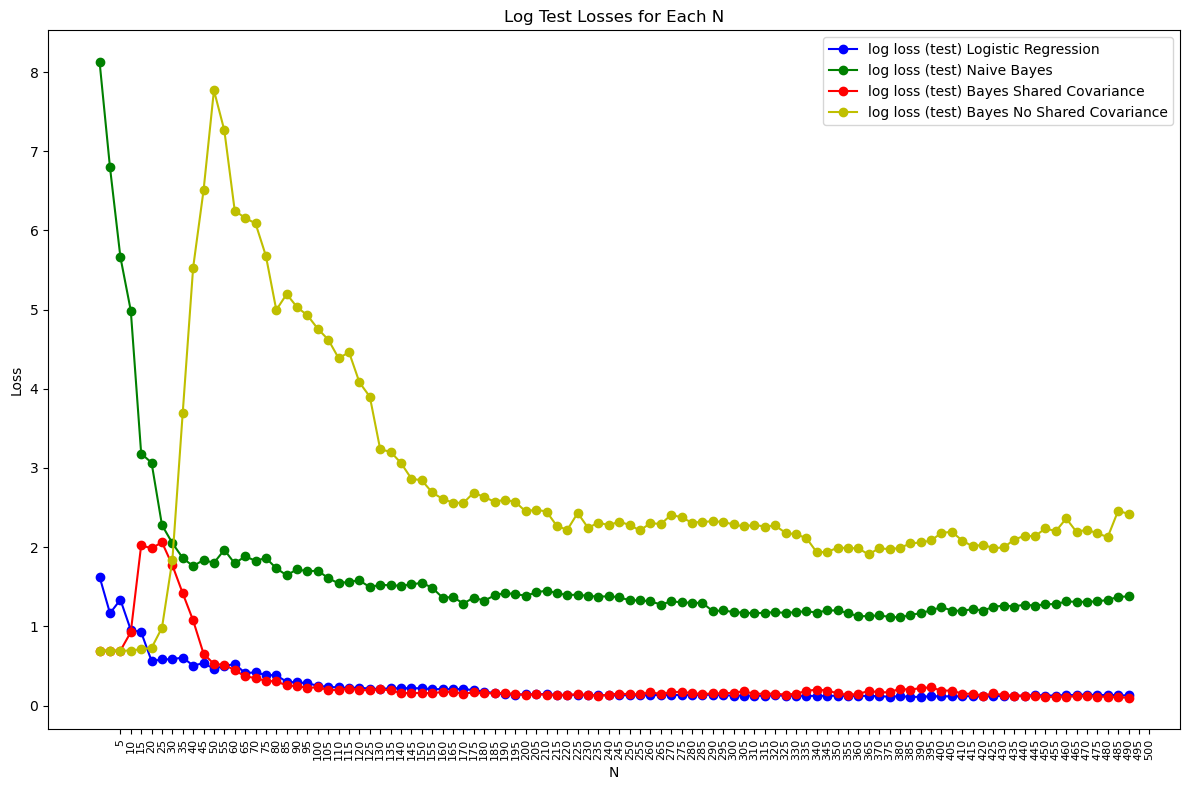

In [13]:
plot_model_performances_N (model_rest_log,model_rest_nb,model_rest_bc_shared,model_rest_bc,4)

**Question 7.4 Analysis**

A) For **Logistic Regression**, we can observe that small training sizes means that it has **low log train loss and essentially 0 0/1 train loss**. This means that it is able to correctly classify each training data by fully fitting it and only has **high confidence in its predictions (through the low log loss)**. The log and 0/1 losses for test data tells a different story as it **remains high throughout the small training sizes** which indicates the model's lack of ability to predict for unseen data (**a telltale sign of overfitting**). As the training data size increases, we can see a steady increase in 0/1 train loss which indicates the model is performing worse when the training data is large (**which might mean that the model is learning the noise from training data instead of useful features**) while log train loss stays relatively similar. However, the test log losses and test 0/1 losses see a steady decrease as training size is larger which also indicates that the model complexity is increasing with the larger training size, thus allowing it to capture more underlying patterns in the data and perform better on unseen data.  

As for **Naive Bayes**, it seems to struggle when training size is small since **three out of four losses for both training and testing are significantly higher than any other models at any stage** which means that is produces unreliable results and is unable to capture any useful patterns (**possibly due to the low model complexity stemming from the conditional independence assumption for Naive Bayes**). As the training size increases, we can see a steady decrease in training 0/1 loss and log loss **but it is still extremely high and stagnates at around 0.07 and 1.4 respectively**. However, the model's testing log and 0/1 losses gets surprisingly low which may indicate that the **conditional independence assumption is reaping its benefits since it helps to ignore irrelevant features and noise, which might be present in this dataset given its large amount of features**.  

Then, we have **Bayes Classifier without a shared covariance matrix** where the log and 0/1 training loss **starts off low and decreases during the initial N increases of the training data** which indicates it's ability to capture the patterns of the training data. However, the testing loss tells a different story where 0/1 loss decreases while log loss increases steadily even during the inital N sizes of training data which seems to tell us that **the model is able to correctly predict the right labels but the confidence in prediction is ldecreasing into a value closer further from 1 and closer to 0.5**. Once the training data size is increase, the log and 0/1 train loss decreases and stagnates and similarly to **Logistic Regression**, the testing log and 0/1 losses also decreases steadily due to the increased model complexity.

Last but not least, we have the **Bayes Cassifier with a shared covariance matrix** where 0/1 and log train loss is extremely low for low training data able to fit and predict its given data relatively accurately. The test log and 0/1 losses however shows high values in initial N size training data sets showing signs of **overfitting and that model complexity is still too high which causes it to capture noise instead**. As we increase the training data, the log and 0/1 train losses see an decrease which is a phenomenon we have seen in the other models. The testing 0/1 and log losses also show a steady decrease which means that our model is able to capture more patterns within the dataset. 

B) According to my observation, I personally think its between Logistic Regression or Bayes Classifier with shared covariance for cases where training size is small because both performs similarly on training data with one having higher log loss (**Logistic Regression**) and one having higher 0/1 loss (**Bayes Classifier with shared covariance**). When looking at test performance, Logistic Regression easily beats out Bayes Classifier which makes it a better choice. This can be attributed to Logistic Regression being a simplier model compared to a Bayesian Model which will allow it to perform better on limited data as more complicated models such as Bayes **have a tendency to overfit when dataset is small and learn useless features / noise**. With a simplier model in Logistic Regression, we can generalize much better on unseen data which can be seen in the test performance as indicated above.

As for larger datasets, I think the choice becomes more muddled as Logistic Regression and Bayes Classifier with shared covariance shows similar performances as N increase. Ultimately, **Bayes Classifier with shared covariance** showed the lowest final log and 0/1 test losses which makes it a good choice since it indicates that the model is a perfect balance between being complex enough to capture the underlying pattern (**along with the interrelationship between the features**) while also being simple enough such that it does not capture too much noise as we can see in the **non-shared covariance** Bayes Classifier model.